In [1]:
import tensorflow_datasets as tfds  # TFDS to download MNIST.
import tensorflow as tf  # TensorFlow / `tf.data` operations.

tf.random.set_seed(0)  # Set the random seed for reproducibility.

train_steps = 1200
eval_every = 200
batch_size = 32

train_ds: tf.data.Dataset = tfds.load('mnist', split='train')
test_ds: tf.data.Dataset = tfds.load('mnist', split='test')

train_ds = train_ds.map(
  lambda sample: {
    'image': tf.cast(sample['image'], tf.float32) / 255,
    'label': sample['label'],
  }
)  # normalize train set
test_ds = test_ds.map(
  lambda sample: {
    'image': tf.cast(sample['image'], tf.float32) / 255,
    'label': sample['label'],
  }
)  # Normalize the test set.

# Create a shuffled dataset by allocating a buffer size of 1024 to randomly draw elements from.
train_ds = train_ds.repeat().shuffle(1024)
# Group into batches of `batch_size` and skip incomplete batches, prefetch the next sample to improve latency.
train_ds = train_ds.batch(batch_size, drop_remainder=True).take(train_steps).prefetch(1)
# Group into batches of `batch_size` and skip incomplete batches, prefetch the next sample to improve latency.
test_ds = test_ds.batch(batch_size, drop_remainder=True).prefetch(1)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling C:\Users\savit\tensorflow_datasets\mnist\incomplete.IWCY1R_3.0.1\mnist-train.tfrecord*...:   0%|    …

Generating test examples...: 0 examples [00:00, ? examples/s]

Shuffling C:\Users\savit\tensorflow_datasets\mnist\incomplete.IWCY1R_3.0.1\mnist-test.tfrecord*...:   0%|     …

Dataset mnist downloaded and prepared to C:\Users\savit\tensorflow_datasets\mnist\3.0.1. Subsequent calls will reuse this data.


In [2]:
from flax import nnx  # The Flax NNX API.
from functools import partial

class CNN(nnx.Module):
  """A simple CNN model."""

  def __init__(self, *, rngs: nnx.Rngs):
    self.conv1 = nnx.Conv(1, 32, kernel_size=(3, 3), rngs=rngs)
    self.conv2 = nnx.Conv(32, 64, kernel_size=(3, 3), rngs=rngs)
    self.avg_pool = partial(nnx.avg_pool, window_shape=(2, 2), strides=(2, 2))
    self.linear1 = nnx.Linear(3136, 256, rngs=rngs)
    self.linear2 = nnx.Linear(256, 10, rngs=rngs)

  def __call__(self, x):
    x = self.avg_pool(nnx.relu(self.conv1(x)))
    x = self.avg_pool(nnx.relu(self.conv2(x)))
    x = x.reshape(x.shape[0], -1)  # flatten
    x = nnx.relu(self.linear1(x))
    x = self.linear2(x)
    return x

# Instantiate the model.
model = CNN(rngs=nnx.Rngs(0))
# Visualize it.
nnx.display(model)

In [3]:
import jax.numpy as jnp  # JAX NumPy

y = model(jnp.ones((1, 28, 28, 1)))
y

Array([[ 0.18405621,  0.50485927,  0.20095949,  0.48739713, -0.37915233,
        -0.5551915 , -0.54481304, -0.04560153,  0.05879352,  0.1333971 ]],      dtype=float32)

In [4]:
import optax

learning_rate = 0.005
momentum = 0.9

optimizer = nnx.Optimizer(model, optax.adamw(learning_rate, momentum))
metrics = nnx.MultiMetric(
  accuracy=nnx.metrics.Accuracy(),
  loss=nnx.metrics.Average('loss'),
)

nnx.display(optimizer)


In [5]:
def loss_fn(model: CNN, batch):
  logits = model(batch['image'])
  loss = optax.softmax_cross_entropy_with_integer_labels(
    logits=logits, labels=batch['label']
  ).mean()
  return loss, logits

@nnx.jit
def train_step(model: CNN, optimizer: nnx.Optimizer, metrics: nnx.MultiMetric, batch):
  """Train for a single step."""
  grad_fn = nnx.value_and_grad(loss_fn, has_aux=True)
  (loss, logits), grads = grad_fn(model, batch)
  metrics.update(loss=loss, logits=logits, labels=batch['label'])  # In-place updates.
  optimizer.update(grads)  # In-place updates.

@nnx.jit
def eval_step(model: CNN, metrics: nnx.MultiMetric, batch):
  loss, logits = loss_fn(model, batch)
  metrics.update(loss=loss, logits=logits, labels=batch['label'])  # In-place updates

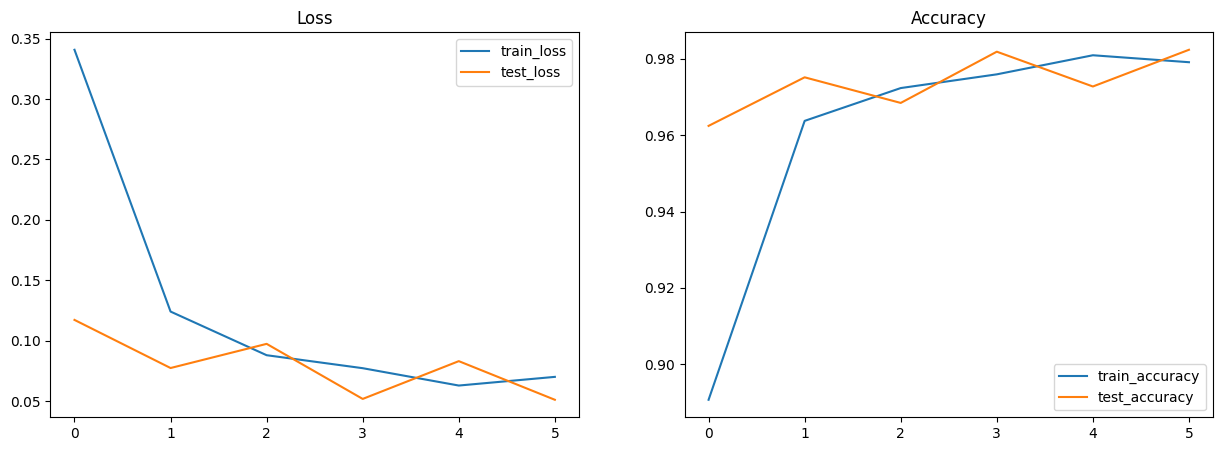

In [6]:
from IPython.display import clear_output
import matplotlib.pyplot as plt

metrics_history = {
  'train_loss': [],
  'train_accuracy': [],
  'test_loss': [],
  'test_accuracy': [],
}

for step, batch in enumerate(train_ds.as_numpy_iterator()):
  # Run the optimization for one step and make a stateful update to the following:
  # - The train state's model parameters
  # - The optimizer state
  # - The training loss and accuracy batch metrics
  train_step(model, optimizer, metrics, batch)

  if step > 0 and (step % eval_every == 0 or step == train_steps - 1):  # One training epoch has passed.
    # Log the training metrics.
    for metric, value in metrics.compute().items():  # Compute the metrics.
      metrics_history[f'train_{metric}'].append(value)  # Record the metrics.
    metrics.reset()  # Reset the metrics for the test set.

    # Compute the metrics on the test set after each training epoch.
    for test_batch in test_ds.as_numpy_iterator():
      eval_step(model, metrics, test_batch)

    # Log the test metrics.
    for metric, value in metrics.compute().items():
      metrics_history[f'test_{metric}'].append(value)
    metrics.reset()  # Reset the metrics for the next training epoch.

    clear_output(wait=True)
    # Plot loss and accuracy in subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    ax1.set_title('Loss')
    ax2.set_title('Accuracy')
    for dataset in ('train', 'test'):
      ax1.plot(metrics_history[f'{dataset}_loss'], label=f'{dataset}_loss')
      ax2.plot(metrics_history[f'{dataset}_accuracy'], label=f'{dataset}_accuracy')
    ax1.legend()
    ax2.legend()
    plt.show()

In [7]:
model.eval() # Switch to evaluation mode.

@nnx.jit
def pred_step(model: CNN, batch):
  logits = model(batch['image'])
  return logits.argmax(axis=1)

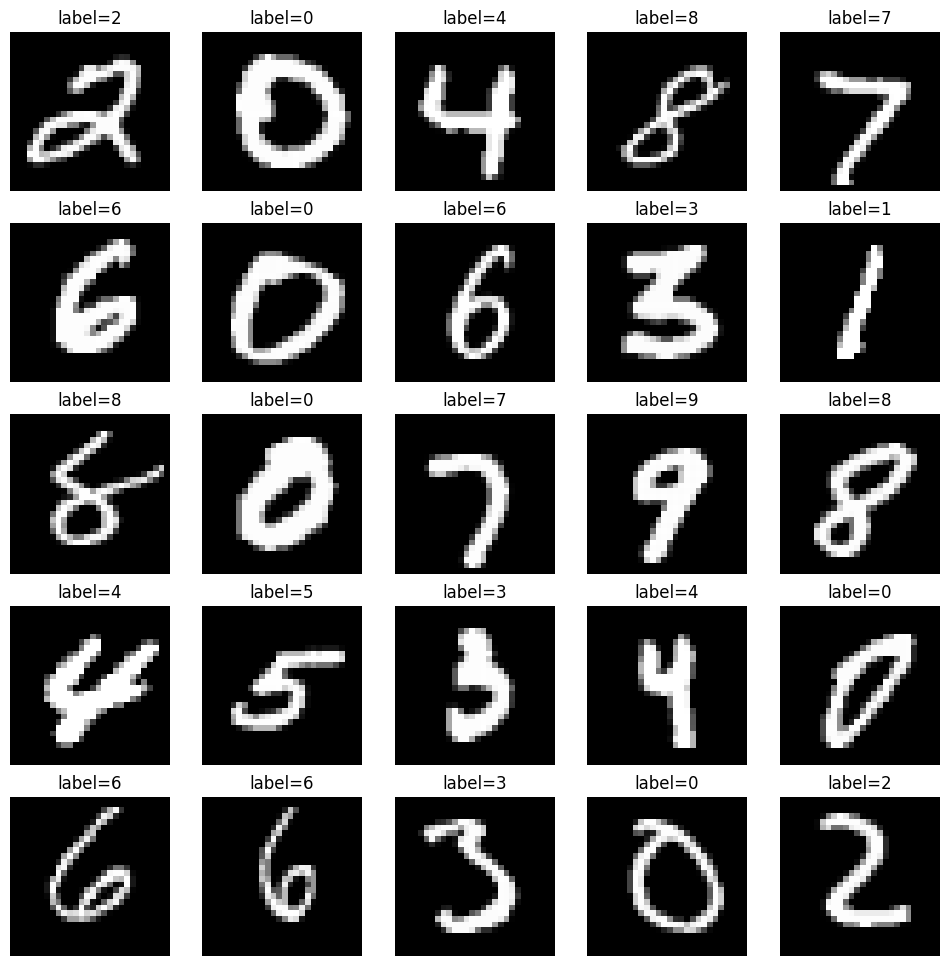

In [8]:
test_batch = test_ds.as_numpy_iterator().next()
pred = pred_step(model, test_batch)

fig, axs = plt.subplots(5, 5, figsize=(12, 12))
for i, ax in enumerate(axs.flatten()):
  ax.imshow(test_batch['image'][i, ..., 0], cmap='gray')
  ax.set_title(f'label={pred[i]}')
  ax.axis('off')